<a href="https://colab.research.google.com/github/Alex-Witt/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_142_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [1]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 2], [1, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 1]
 [2 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [2]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=32.534042246007864, pvalue=8.61633328275472e-08)


In [3]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [4]:
gender = ['male', 'male','male','female','female','female']
eats_outside = ['outside','inside','inside','inside','outside','outside']

import pandas as pd

df = pd.DataFrame({'gender': gender, 'preference':eats_outside})
df.head(6)

,gender,preference
0,male,outside
1,male,inside
2,male,inside
3,female,inside
4,female,outside
5,female,outside


In [5]:
pd.crosstab(df.gender, df.preference, margins = True)

preference,inside,outside,All
gender,,,
female,1,2,3
male,2,1,3
All,3,3,6


In [6]:
df = df.replace("male", 0)
df = df.replace("female", 1)
df = df.replace('inside', 1)
df = df.replace('outside', 0)

df.head()

,gender,preference
0,0,0
1,0,1
2,0,1
3,1,1
4,1,0


In [7]:
pd.crosstab(df.gender, df.preference, margins = True)

expected = np.array([[6/4,6/4],
                    [6/4,6/4]])

# Let's think about marginal proportions
## n of males = 3
## n of females = 3
## n of outside = 3
## n of inside = 3

# Marginal Proportion of the first row
# obs / total = (3 males) / (6 Humans)

pd.crosstab(df.gender, df.preference, margins = True, normalize = 'all')

#observed is a table of the marginal proportions of each subgroup
observed = np.array([[.5,.5],
                    [.5,.5]])

deviation = numerator = observed - expected
print(numerator)

deviation_squared = deviation**2
print()
print('Deviation Squared:', deviation_squared)
print()

fraction = (deviation_squared / expected)
print(fraction)
print()

chi2 = fraction.sum()
print(chi2/4)

[[-1. -1.]
 [-1. -1.]]

Deviation Squared: [[1. 1.]
 [1. 1.]]

[[0.66666667 0.66666667]
 [0.66666667 0.66666667]]

0.6666666666666666


In [8]:
chi_data = [[1,2],[2,1]]

from scipy.stats import chisquare

chisquare(chi_data, axis= None)

Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)

In [9]:
from scipy.stats import chi2_contingency 


table = [[1,2],[2,4]]

chi2statistic, pvalue, dof, observed = chi2_contingency(table)

print("chi2 stat", chi2statistic)
print("p-value", pvalue)
print('degrees of freedom', dof)
print("Contingency Table: \n", observed)

chi2 stat 0.0
p-value 1.0
degrees of freedom 1
Contingency Table: 
 [[1. 2.]
 [2. 4.]]


In [10]:
def lazy_chisquare(observed, expected):
  chisquare = 0
  for row_obs, row_exp in zip(observed, expected):
    for obs, exp in zip(row_obs, row_exp):
      chisquare += (obs - exp)**2 / exp
  return chisquare

chi_data = [[1, 2], [2, 1]]
expected_values = [[1.5, 1.5], [1.5, 1.5]]
chistat = lazy_chisquare(chi_data, expected_values)
chistat

0.6666666666666666

## Confidence Intervals

In [11]:
# confidence_interval = [lower_bound, upper_bound]

coinflips = np.random.binomial(n=1, p=.5, size = 100)

print(coinflips)

[0 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1
 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0
 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0]


In [12]:
import scipy.stats as stats

stats.ttest_1samp(coinflips, 0.5)

Ttest_1sampResult(statistic=2.0310096011589898, pvalue=0.04493472521263044)

In [0]:
# Confidence intervals!
# Similar to hypothesis testing, but centered at sample mean
# Generally better than reporting the "point estimate" (sample mean)
# Why? Because point estimates aren't always perfect

import numpy as np
from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
  return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
  
  Returns:
    None, but prints to screen the report
  """
  #print('Mean: {}'.format(confidence_interval[0]))
  #print('Lower bound: {}'.format(confidence_interval[1]))
  #print('Upper bound: {}'.format(confidence_interval[2]))
  s = "our mean lies in the interval [{:.2}, {:.2}]".format(
      confidence_interval[1], confidence_interval[2])
  return s

In [14]:
coinflip_interval = confidence_interval(coinflips)  # Default 95% conf
coinflip_interval


print(.68 - .58697)

print(.68 - .77303)

0.09303000000000006
-0.09302999999999995


## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

### Solution:

I hypothesis that political parties vote in blocks, averaging around an 80~20 ratio. Therefore I will be testing against a null hypothesis that the weight of support (mean of individuals for or against a bill) is either 80% (in favor) or 20% (against). 

In [15]:
df = pd.read_csv('https://www.dropbox.com/s/eykydmqlt003trd/house-votes-84.data?dl=1', 
                 na_values = ['?'] , 
                 header = None,
                 names = ['Party','handicapped-infants','water',
                          'budget','health_costs',
                          'el_salvador','religious_groups_in_school','anti_satellite_wep',
                          'contra','mx_missile','immigration',
                          'synfuel','education',
                          'superfund','crime','duty_free_export',
                          'south_africa'])

df = df.replace({'n': 0 , 'y': 1})

dem = df.loc[df['Party'] == 'democrat']
rep = df.loc[df['Party'] == 'republican']

print(df.shape)
print()
print(df.info())
print()
print(df.isnull().sum())
print()
df.head()

(435, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
Party                         435 non-null object
handicapped-infants           423 non-null float64
water                         387 non-null float64
budget                        424 non-null float64
health_costs                  424 non-null float64
el_salvador                   420 non-null float64
religious_groups_in_school    424 non-null float64
anti_satellite_wep            421 non-null float64
contra                        420 non-null float64
mx_missile                    413 non-null float64
immigration                   428 non-null float64
synfuel                       414 non-null float64
education                     404 non-null float64
superfund                     410 non-null float64
crime                         418 non-null float64
duty_free_export              407 non-null float64
south_africa                  331 non-null float64
dtypes: float64(16

,Party,handicapped-infants,water,budget,health_costs,el_salvador,religious_groups_in_school,anti_satellite_wep,contra,mx_missile,immigration,synfuel,education,superfund,crime,duty_free_export,south_africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
bills = ['handicapped-infants', 'water', 'budget', 'health_costs',
       'el_salvador', 'religious_groups_in_school', 'anti_satellite_wep',
       'contra', 'mx_missile', 'immigration', 'synfuel', 'education',
       'superfund', 'crime', 'duty_free_export', 'south_africa']
parties = ['republicans','democrats']

In [0]:
# Placing this here so I can play with the confidence interval. 


def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
  return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
  
  Returns:
    None, but prints to screen the report
  """
  #print('Mean: {}'.format(confidence_interval[0]))
  #print('Lower bound: {}'.format(confidence_interval[1]))
  #print('Upper bound: {}'.format(confidence_interval[2]))
  s = "our mean lies in the interval [{:.2}, {:.2}]".format(
      confidence_interval[1], confidence_interval[2])
  return s

In [0]:
def conf (party, bill):    # This function to call a function just adds the dropna
  r = confidence_interval(party[bill].dropna())   
  return r             # To make it work with how I cleaned (or didn't) my data

In [0]:
r_upper = []        # Creating a bunch of lists to append
r_lower = []        # These will be used as my columns in a new Dataframe
r_mean = []

d_upper = []
d_lower = []
d_mean = []


for bill in bills:
                  #I also want to bring the values up to percentages. It looks nicer. 
  r_upper.append(conf(rep,bill)[2]*100)
  r_lower.append(conf(rep,bill)[1]*100)
  r_mean.append(conf(rep,bill)[0]*100)
    
  d_upper.append(conf(dem,bill)[2]*100)
  d_lower.append(conf(dem,bill)[1]*100)
  d_mean.append(conf(dem,bill)[0]*100)


    ### New Dataframe with Confidence Intervals 

vc = pd.DataFrame({"Bill": bills, 'R Upper Limit': r_upper, 'R Lower Limit': r_lower, 
                   'Republican Support': r_mean, 'D Upper Limit': d_upper, 'D Lower Limit': d_lower, 
                   'Democrat Support': d_mean, "Null Hypothesis Rejected": True})  
         # I also want to create a Null Hypothesis Rejected column to be appended later. 

In [20]:
vc

,Bill,D Lower Limit,D Upper Limit,Democrat Support,Null Hypothesis Rejected,R Lower Limit,R Upper Limit,Republican Support
0,handicapped-infants,54.459270,66.470963,60.465116,True,12.765166,24.810591,18.787879
1,water,43.824514,56.593896,50.209205,True,42.526571,58.824780,50.675676
2,budget,84.994352,92.697956,88.846154,True,8.143520,18.685748,13.414634
3,health_costs,2.633186,8.177625,5.405405,True,97.100674,100.475083,98.787879
4,el_salvador,16.486311,26.650944,21.568627,True,91.839795,98.463236,95.151515
5,religious_groups_in_school,41.539183,53.809655,47.674419,True,85.098749,94.419324,89.759036
6,anti_satellite_wep,72.078202,82.361952,77.220077,True,17.420089,30.728059,24.074074
7,contra,78.308452,87.471016,82.889734,True,9.595477,20.977771,15.286624
8,mx_missile,70.439401,81.173502,75.806452,True,6.593486,16.436817,11.515152
9,immigration,41.075744,53.220834,47.148289,True,48.099596,63.415556,55.757576


In [0]:
upper_hypothesis = 80    # Upper Null Hypothesis for Bills a party supports 
lower_hypothesis = 20    # Lower Null Hypothesis for Bills a Party opposes

names = []
       ##This list is setting up my condition for determining if the null hypothesis is rejected. 
names.append(vc[(upper_hypothesis <= vc['D Upper Limit']) &
                (vc['D Lower Limit'] <= upper_hypothesis)].Bill.tolist())
names.append((vc[(lower_hypothesis <= vc['D Upper Limit']) &
                 (vc['D Lower Limit'] <= lower_hypothesis)]).Bill.tolist())
names.append((vc[(upper_hypothesis <= vc['R Upper Limit']) &
                 (vc['R Lower Limit'] <= upper_hypothesis)]).Bill.tolist())
names.append((vc[(lower_hypothesis <= vc['R Upper Limit']) &
                 (vc['R Lower Limit'] <= lower_hypothesis)]).Bill.tolist())

flat_list = []  ## The above method creates a list of lists. This flattens the list
for sublist in names:
    for item in sublist:
        flat_list.append(item)
        
names = list(set(flat_list))   ##This returns only unique values in my list. 

   ## Now to replace True values with False where the Null Hypothesis is not rejected. 
vc.loc[vc['Bill'].isin(names), "Null Hypothesis Rejected"] = False  

In [22]:
vc

,Bill,D Lower Limit,D Upper Limit,Democrat Support,Null Hypothesis Rejected,R Lower Limit,R Upper Limit,Republican Support
0,handicapped-infants,54.459270,66.470963,60.465116,False,12.765166,24.810591,18.787879
1,water,43.824514,56.593896,50.209205,True,42.526571,58.824780,50.675676
2,budget,84.994352,92.697956,88.846154,True,8.143520,18.685748,13.414634
3,health_costs,2.633186,8.177625,5.405405,True,97.100674,100.475083,98.787879
4,el_salvador,16.486311,26.650944,21.568627,False,91.839795,98.463236,95.151515
5,religious_groups_in_school,41.539183,53.809655,47.674419,True,85.098749,94.419324,89.759036
6,anti_satellite_wep,72.078202,82.361952,77.220077,False,17.420089,30.728059,24.074074
7,contra,78.308452,87.471016,82.889734,False,9.595477,20.977771,15.286624
8,mx_missile,70.439401,81.173502,75.806452,False,6.593486,16.436817,11.515152
9,immigration,41.075744,53.220834,47.148289,True,48.099596,63.415556,55.757576


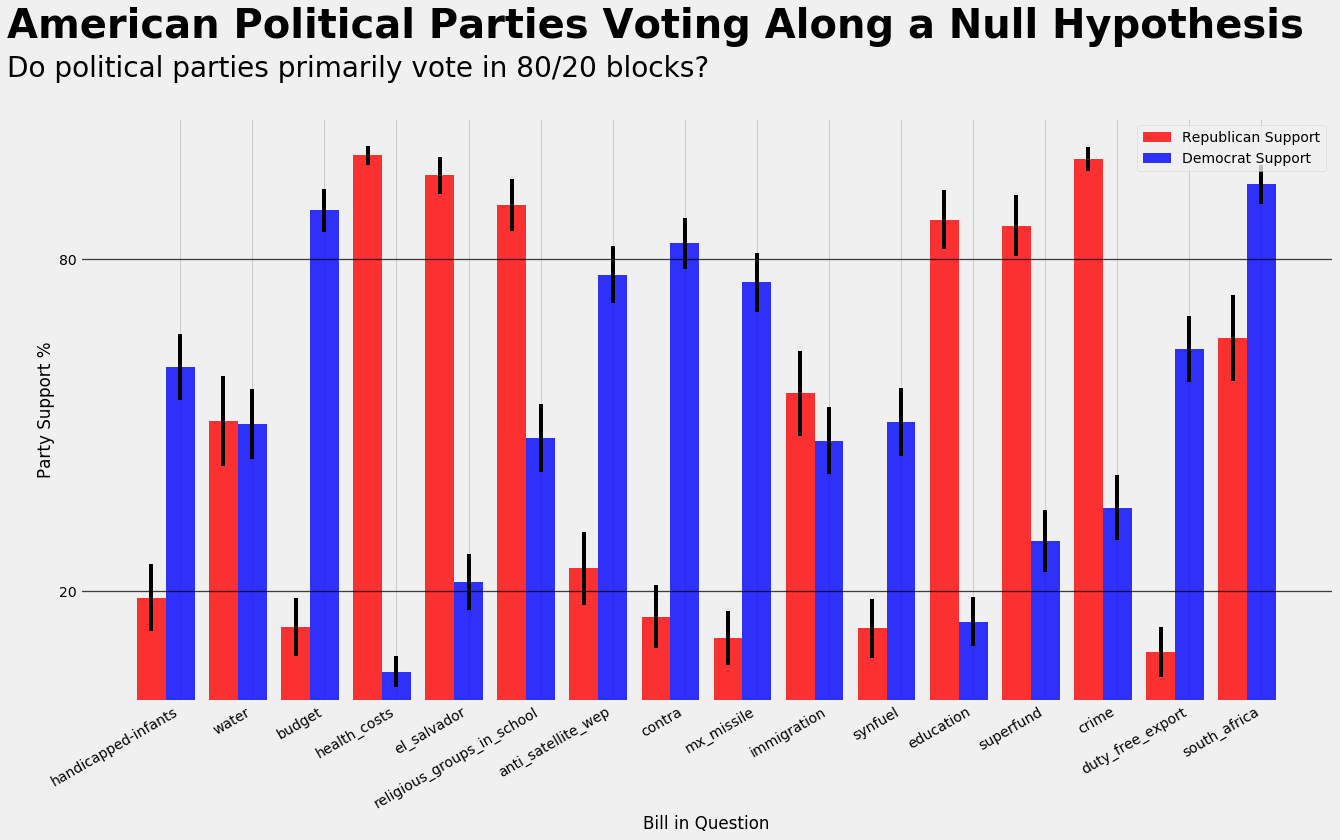

In [24]:
import matplotlib.pyplot as plt

# Setting up my plot!

plt.style.use('fivethirtyeight')

n_groups = vc['Bill'].nunique()

fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8

rep = plt.bar(index,vc['Republican Support'], 
              bar_width,
              alpha=opacity,
              color='red',
              label='Republican Support',
              yerr = (vc['R Upper Limit']-vc['Republican Support']))

dem = plt.bar(index + bar_width, vc['Democrat Support'], 
              bar_width,
              alpha=opacity,
              color='blue',
              label='Democrat Support',
              yerr = (vc['D Upper Limit']-vc['Democrat Support']))

plt.axhline(y = 20, color = 'black', linewidth = 1.3, alpha = .7) 
plt.axhline(y = 80, color = 'black', linewidth = 1.3, alpha = .7) 
ax.set_yticks([20, 80])

plt.xlabel('Bill in Question')
plt.ylabel('Party Support %')
ax.text(x=-2,y=120, s = "American Political Parties Voting Along a Null Hypothesis",
       fontsize = 40, fontweight = 'bold')
ax.text(x=-2,y=113, s = "Do political parties primarily vote in 80/20 blocks?",
       fontsize = 28)
plt.xticks(index + bar_width, vc['Bill'], rotation = 30, ha='right')
plt.legend()

plt.show();

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)